In [2]:
import os

os.chdir("credit_card_transactions_fraud_detection")

In [3]:
!pip install pip upgrade
!pip install -r requirements.txt --quiet

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.3.1 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
bigframes 0.22.0 requires sqlglot<20,>=19.9.0, but you have sqlglot 26.0.1 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
conda 24.5.0 requires pa

In [4]:
import warnings

warnings.filterwarnings('error', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
import os
import pretty_errors
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from sklearn.metrics import classification_report
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

In [7]:
import numpy as np
from src.processing import * 

In [8]:
import logging
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("credit_card_fraud_analysis") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.debug.maxToStringFields", "100") \
    .getOrCreate()

# Set Spark log level to ERROR to suppress most logs
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 21:17:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
data = spark.read.csv("/kaggle/input/processed-data/processed_data", header=True, inferSchema=True)
cols_to_drop = ['portion', 'lat', 'long', 'merch_lat', 'merch_long', 'distance_km', 'state', 'city']
data = data.drop(*cols_to_drop)
data.show(5)

+--------------------+-------------+------+------+--------+--------------------+--------+---+-----------+----------+-----------------+------------------+-----------------+
|            merchant|     category|   amt|gender|city_pop|                 job|is_fraud|age|trans_month|trans_hour|trans_day_of_week|trans_day_of_month|trans_day_of_year|
+--------------------+-------------+------+------+--------+--------------------+--------+---+-----------+----------+-----------------+------------------+-----------------+
|fraud_Raynor, Rei...|gas_transport| 61.15|     M|     140|Development worke...|       0| 35|          8|        10|                1|                 4|              216|
|fraud_Vandervort-...|  grocery_pos| 55.25|     M|    3776|Sport and exercis...|       0| 48|          8|        10|                1|                 4|              216|
| fraud_Stracke-Lemke|  grocery_pos| 74.98|     M|    2836| Designer, jewellery|       0| 39|          8|        10|                1|      

In [10]:
print(data.columns)

['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'is_fraud', 'age', 'trans_month', 'trans_hour', 'trans_day_of_week', 'trans_day_of_month', 'trans_day_of_year']


In [11]:
# Split data into training and testing sets
train_data = data.where(col('portion') == 'train')
test_data = data.where(col('portion') == 'test')
del data

In [12]:
train_sample = train_data.sampleBy('is_fraud', fractions={0: 0.10, 1: 1.0}, seed=123)
del train_data

In [13]:
from pyspark.ml import PipelineModel

pipeline = PipelineModel.load('saved_models/GBTClassifier')

In [14]:
def get_probability(vector, index):
    return float(vector[index])

get_probability_udf = udf(lambda v: get_probability(v, 1), DoubleType())

In [36]:
thresholds = np.arange(0.1, 1.0, 0.025) 
metrics = []

print(thresholds)

[0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675
 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975]


In [37]:
train_sample.cache()

preds = pipeline.transform(train_sample)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction_double", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction_double", metricName="weightedRecall")

for threshold in tqdm(thresholds, desc="Optimizing threshold for GBTClassifier"):
    thresholded_preds = preds.withColumn(
        "prediction_double",
        (get_probability_udf(col("probability")) > threshold).cast(DoubleType())
    )
    
    precision = precision_evaluator.evaluate(thresholded_preds)
    recall = recall_evaluator.evaluate(thresholded_preds)
    
    metrics.append((threshold, precision, recall))

best_threshold = max(metrics, key=lambda x: x[1])  
print(f"Best threshold: {best_threshold[0]}, Precision: {best_threshold[1]}, Recall: {best_threshold[2]}") 

Optimizing threshold for GBTClassifier: 100%|██████████| 36/36 [03:12<00:00,  5.34s/it]


Best threshold: 0.3999999999999999, Precision: 0.9852216298436225, Recall: 0.9852943414025531


In [42]:
metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall"])
metrics_df.head(5)

,Threshold,Precision,Recall
0,0.100,0.983680,0.984184
1,0.125,0.984051,0.984488
2,0.150,0.984271,0.984663
3,0.175,0.984399,0.984762
4,0.200,0.984506,0.984845


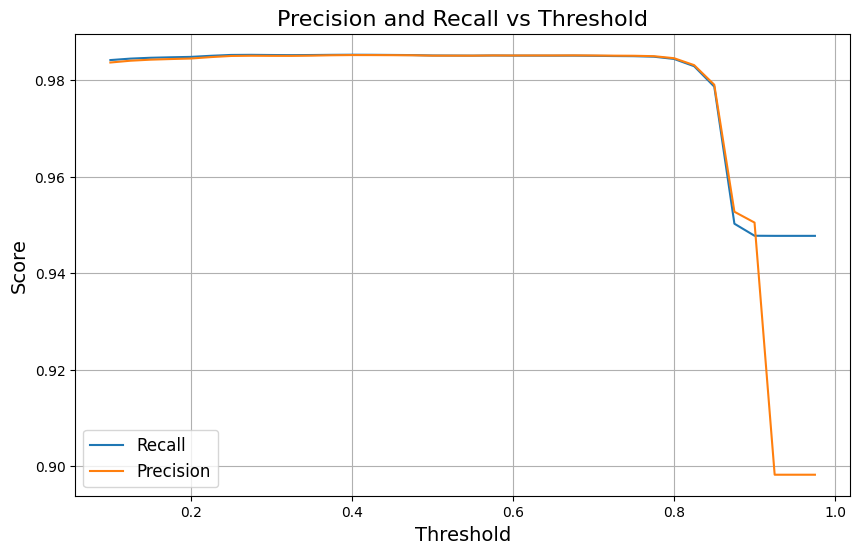

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision')
plt.title("Precision and Recall vs Threshold", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Metrics on test data

In [45]:
test_preds = pipeline.transform(test_data)
test_preds = test_preds.withColumn(
    "final_prediction",
    (get_probability_udf(col("probability")) > 0.6).cast(DoubleType())
)

test_labels = test_preds.select("is_fraud").rdd.flatMap(lambda x: x).collect()
test_predictions = test_preds.select("final_prediction").rdd.flatMap(lambda x: x).collect()

test_report = classification_report(test_labels, test_predictions)
print("Classification Report for Test Set:")
print(test_report)

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535609
           1       0.79      0.71      0.75      1957

    accuracy                           1.00    537566
   macro avg       0.89      0.85      0.87    537566
weighted avg       1.00      1.00      1.00    537566

